# Playing with Raw Images in Python using `rawpy`

Faisal Qureshi      
http://www.vclab.ca

In [155]:
import rawpy
import imageio
import matplotlib.pyplot as plt
import numpy as np

In [160]:
def imshow(image, title=None):
    plt.axis('off')
    if title:
        plt.title(f'{title} ({image.shape[0]} x {image.shape[1]})')
    else:
        plt.title(f'{image.shape[0]} x {image.shape[1]}')
    plt.imshow(image)

## Raw image files

A raw image file format, often referred to simply as "RAW," is a file format that captures and stores image data directly from the sensor of a digital camera without any in-camera processing. Unlike standard image formats such as JPEG or PNG, which undergo compression and often lose some data, raw files retain the fullest amount of information captured by the sensor. This provides photographers with greater flexibility during post-processing, allowing for detailed adjustments in exposure, color balance, and other parameters without compromising image quality. However, because RAW files are not standardized across camera manufacturers, proprietary software or specific image editors are often required to view and process these files.

The following is taken from ChatGPT.

RAW image file formats vary by camera manufacturer, each having its proprietary format. Here are some popular RAW file formats by brand:

- Canon: .CR2, .CR3
- Nikon: .NEF, .NRW
- Sony: .ARW, .SRF, .SR2
- Olympus: .ORF
- Panasonic: .RW2
- Fujifilm: .RAF
- Pentax: .PEF, .DNG (Pentax sometimes uses the universal Digital Negative format created by Adobe)
- Leica: .DNG (Leica mainly uses the Digital Negative format, though they have proprietary formats for some older models)
- Hasselblad: .3FR, .FFF
- Sigma: .X3F
- Kodak: .KDC, .DCR, .DRF
- Epson: .ERF
- Mamiya: .MEF

While there are many other manufacturers and formats, these are some of the most common. Remember, RAW formats are proprietary, so the exact specifications can differ even among cameras from the same manufacturer. Adobe's .DNG (Digital Negative) format aims to be a universal RAW format, and some manufacturers and photographers have adopted it, but many still use their proprietary formats.

In [161]:
image_file = 'L1004432.DNG' # Adobe digital negative format

Use `rawpy` package to read this file.

In [162]:
raw = rawpy.imread(image_file)

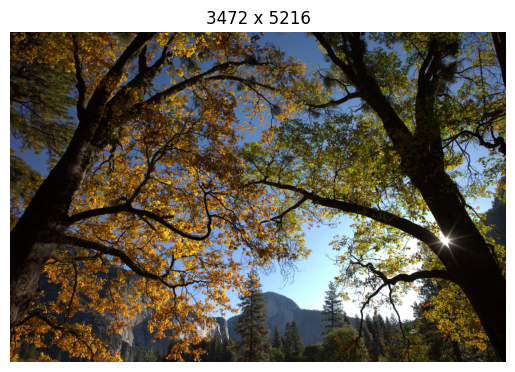

In [163]:
image = raw.postprocess()
imshow(image)

## color_desc

Bayer pattern

In [164]:
print(raw.color_desc)

b'RGBG'


## color_matrix

The columns correspond to the RGB values and an additional scaling/offset factor:

- The first column is for the Red channel of the camera's sensor data.
- The second column is for the Green channel.
- The third column is for the Blue channel.
- The fourth column is the offset (or sometimes a scaling factor) for each XYZ component.

The transformation is typically applied as a matrix multiplication, where you multiply the 3x4 color matrix by a 4x1 vector that represents the camera's RGB sensor data and an additional 1 (to accommodate the fourth column). The result is the XYZ values for that specific sensor data point.

Do note that while some camera profiles may provide a 3x4 matrix, many others might just provide a 3x3 matrix. The 3x3 matrix is more common and standard in many cases. The 3x4 is an extended version to offer more flexibility or precision in the transformation.







In [165]:
print(raw.color_matrix)

[[ 2.036414   -0.88692397 -0.1494899   0.        ]
 [-0.28415313  1.714794   -0.43064094  0.        ]
 [ 0.05597014 -0.6613422   1.6053721   0.        ]]


## num_colors, raw_pattern, raw_type

Number of colors.  Note that some cameras emply two different green colors.  In this case `num_colors` is 4.

The raw_type attribute will return an enum that can have various values:

- `rawpy.RawType.FULL`: The image has unscaled colors for each pixel.
- `rawpy.RawType.BAYER`: The image data is in a Bayer pattern. Most color digital cameras use a Bayer filter mosaic to capture color information, with alternating rows of red-green and green-blue filters. The exact pattern might vary based on the camera (RGGB, BGGR, etc.), but it's a type of single-chip color sensor layout.
- `rawpy.RawType.FUJI_XTRANS`: The image data comes from a Fuji camera that uses the X-Trans sensor. This is a more complex 6x6 filter pattern developed by Fujifilm, which is supposed to provide better color accuracy and detail compared to traditional Bayer patterns.
- `rawpy.RawType.FUJI16`: The image data comes from some Fujifilm cameras that utilize a 16-bit format.
- `rawpy.RawType.FUJI`: A generic Fuji raw layout.
- `rawpy.RawType.UNDEFINED`: The raw type is not defined, or the library cannot determine it.
- `rawpy.RawType.FLAT`: The RAW data is in a "flat" format. This typically means the RAW data is a linear dump of pixel values without any specific mosaic pattern (like the Bayer pattern or X-Trans).

In [166]:
print(raw.num_colors)
print(raw.raw_pattern)
print(raw.raw_type)

3
[[0 1]
 [1 2]]
RawType.Flat


## raw_image

In [167]:
print(raw.raw_image.shape)

(3472, 5216)


## From raw to RGB

### Scaling the raw image intensities between 0 and 1

In [168]:
image = np.array(raw.raw_image, dtype=np.double)
black = np.array(raw.black_level_per_channel, dtype=np.double)
black = np.reshape(black, (2,2))
black = np.tile(black, (image.shape[0]//2, image.shape[1]//2))

print('Shape of the image and black image')
print(image.shape)
print(black.shape)

image = (image - black) / (raw.white_level - black)

Shape of the image and black image
(3472, 5216)
(3472, 5216)


### Deal with mosaic pattern

In [169]:
num_colors = raw.num_colors
colors = np.frombuffer(raw.color_desc, dtype=np.byte)

print(f'num_colors = {num_colors}')
print(raw.color_desc)
print(colors)

num_colors = 3
b'RGBG'
[82 71 66 71]


In [170]:
pattern = np.array(raw.raw_pattern)
index_0 = np.where(colors[pattern] == colors[0])
index_1 = np.where(colors[pattern] == colors[1])
index_2 = np.where(colors[pattern] == colors[2])
index_3 = np.where(colors[pattern] == colors[3])

### White balance

In [171]:
wb_c = raw.camera_whitebalance 
print('Camera whitebalance:')
print(wb_c)

wb = np.zeros((2, 2), dtype=np.double) 
wb[index_0] = wb_c[0] / wb_c[1]
wb[index_1] = wb_c[1] / wb_c[1]
wb[index_2] = wb_c[2] / wb_c[1]

if num_colors == 4:
    wb[index_3] = wb_c[3] / wb_c[1]

wb = np.tile(wb, (image.shape[0]//2, image.shape[1]//2))
image_wb = np.clip(image * wb, 0, 1)

Camera whitebalance:
[2.57769775390625, 1.0, 1.092529296875, 0.0]


### Demosaic

In [172]:
image_demosaiced = np.empty((image_wb.shape[0]//2, image_wb.shape[1]//2, num_colors))

if num_colors == 3:
    image_demosaiced[:, :, 0] = image_wb[index_0[0][0]::2, index_0[1][0]::2]
    image_demosaiced[:, :, 1]  = (image_wb[index_1[0][0]::2, index_1[1][0]::2] + image_wb[index_1[0][1]::2, index_1[1][1]::2]) / 2
    image_demosaiced[:, :, 2]  = image_wb[index_2[0][0]::2, index_2[1][0]::2]
else: # n_colors == 4
    image_demosaiced[:, :, 0] = image_wb[index_0[0][0]::2, index_0[1][0]::2]
    image_demosaiced[:, :, 1] = image_wb[index_1[0][0]::2, index_1[1][0]::2]
    image_demosaiced[:, :, 2] = image_wb[index_2[0][0]::2, index_2[1][0]::2]
    image_demosaiced[:, :, 3] = image_wb[index_3[0][0]::2, index_3[1][0]::2]

#### Colors

In [173]:
XYZ_to_cam = np.array(raw.rgb_xyz_matrix[0:num_colors, :], dtype=np.double)

print('XYZ_to_cam:')
print(XYZ_to_cam)

sRGB_to_XYZ = np.array([[0.4124564, 0.3575761, 0.1804375],
                        [0.2126729, 0.7151522, 0.0721750],
                        [0.0193339, 0.1191920, 0.9503041]], dtype=np.double)
print('sRGB_to_XYZ:')
print(sRGB_to_XYZ)

sRGB_to_cam = np.dot(XYZ_to_cam, sRGB_to_XYZ)
print('sRGB_to_cam:')
print(sRGB_to_cam)

norm = np.tile(np.sum(sRGB_to_cam, 1), (3, 1)).transpose()
sRGB_to_cam = sRGB_to_cam / norm
print('sRGB_to_cam (normalized by the sum of each row):')
print(sRGB_to_cam)

if num_colors == 3:
    cam_to_sRGB = np.linalg.inv(sRGB_to_cam)
else: # n_colors == 4
    cam_to_sRGB = np.linalg.pinv(sRGB_to_cam)
print('cam_to_sRGB:')
print(cam_to_sRGB)

XYZ_to_cam:
[[ 0.66869998 -0.1751     -0.0291    ]
 [-0.3556      1.13730001  0.2492    ]
 [-0.0548      0.22040001  0.71460003]]
sRGB_to_XYZ:
[[0.4124564 0.3575761 0.1804375]
 [0.2126729 0.7151522 0.072175 ]
 [0.0193339 0.119192  0.9503041]]
sRGB_to_cam:
[[0.23800795 0.11041949 0.08036686]
 [0.1000214  0.71589119 0.25473684]
 [0.0380865  0.22319898 0.68510673]]
sRGB_to_cam (normalized by the sum of each row):
[[0.55506322 0.25751157 0.18742521]
 [0.09342125 0.66865135 0.2379274 ]
 [0.04024389 0.23584195 0.72391416]]
cam_to_sRGB:
[[ 1.93052752 -0.6415659  -0.28896163]
 [-0.26189744  1.77868887 -0.51679143]
 [-0.0219992  -0.54380804  1.56580724]]


Suppose cam_to_sRGB is a 3x3 matrix representing a transformation from camera RGB to standard sRGB.

image_demosaiced could be an image with shape (height, width, 3), where the last dimension has RGB values for each pixel.

The np.einsum expression will apply the cam_to_sRGB matrix transformation to each RGB pixel in image_demosaiced.

The result will be a new image, still of shape (height, width, 3), but where the RGB values of each pixel have been transformed by the cam_to_sRGB matrix.

In [174]:
image_sRGB = np.einsum('ij,...j', cam_to_sRGB, image_demosaiced)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


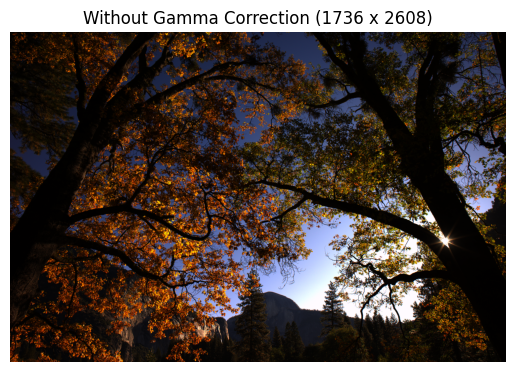

In [175]:
imshow(image_sRGB, 'Without Gamma Correction')

### Gamma Correction

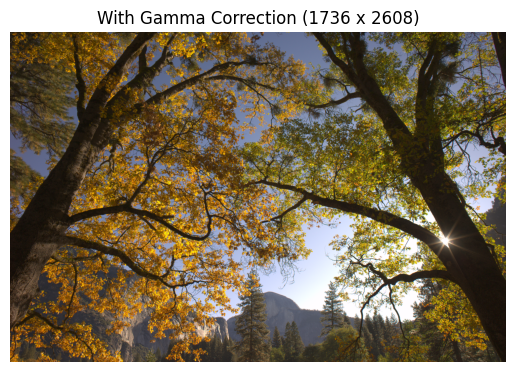

In [176]:
image_sRGB_gamma_corrected = np.clip(image_sRGB, 0.0, 1.0) ** (1/2.2)

imshow(image_sRGB_gamma_corrected, 'With Gamma Correction')